In [86]:
!pip install torch==1.6.0 torchvision==0.7.0

     |████████████████████████████████| 748.8MB 17kB/s 
     |████████████████████████████████| 5.9MB 27.8MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


# Загрузка библиотек



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
from google.colab import files

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### устанавливаемым настройки обработки

In [3]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# Загрузка данных




In [4]:
file = files.upload()

Saving formatted_movie_lines.txt to formatted_movie_lines.txt
Saving movie_conversations.txt to movie_conversations.txt
Saving movie_lines.txt to movie_lines.txt


### посмотрим на содержимое данных

In [4]:
corpus_name = "movie-dialogs"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines("movie_lines.txt")

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


### подготавливаем данные

Разбиваем каждую строку файла на словарь полей

In [5]:
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines

группируем поля строк в диалоги

In [6]:
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # извлекаем поля
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # преобразуем строку в список (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # собираем
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations

извлекаем пары предложений из разговора

In [7]:
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # преобразуем все строки разговора
        for i in range(len(conversation["lines"]) - 1): # игнорируем последнюю строку(для нее нет ответа)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Fфильтруем неправильные образцы (если один из списков пуст)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

### собирем все в один файл

определяем новый файл

In [8]:
datafile = ("formatted_movie_lines.txt")
delimiter = '\t'
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

### инициализируем строки, список разговоров и идентификаторы поле

In [9]:
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

### загружаем строки и обрабатываем разговоры

In [10]:
print("\nОбработка корпуса...")
lines = loadLines("movie_lines.txt", MOVIE_LINES_FIELDS)
print("\nЗагрузка разговоров...")
conversations = loadConversations("movie_conversations.txt", lines, MOVIE_CONVERSATIONS_FIELDS)


Обработка корпуса...

Загрузка разговоров...


сохраняем в CSV

In [11]:
print("\nСохраняем в новом отформатированном формате...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)


Сохраняем в новом отформатированном формате...


### посмотрим что получилось

In [12]:
print("\nПримеры строк из файла:")
printLines(datafile)


Примеры строк из файла:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\tSeems like she could get a date easy enough...\n"
b'Why?\tUnso

## токены слов по умолчанию

In [13]:
PAD_token = 0  # для заполнения коротких предложений
SOS_token = 1  # начало предложения
EOS_token = 2  # конец предложения

In [14]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # подсчитать SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Rудалить слова ниже определенного порога подсчета
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # повторно инициализируем словарь
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 

        for word in keep_words:
            self.addWord(word)

# Собираем словарь и пары предложений вопрос/ответ

### Максимальная длина предложения для 

In [15]:
MAX_LENGTH = 10 

### преобразуем строки Unicode в ASCII

In [16]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

### чистим и нормализуем

In [17]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

### чтение пары вопрос/ответ и возвращаем VOC

In [18]:
def readVocs(datafile, corpus_name):
    print("Чтение строк...")
    # читаем файл и разбиваем на строки
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # разбиваем каждую строку на пары и нормализуем
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

### возвращаем True, если оба предложения в паре находятся ниже порога MAX_LENGTH

In [19]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

### фильтруем пары

In [20]:
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### собираем все в одно

In [21]:
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Начать подготовку данных для обучения ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Прочитано {!s} пар предложений".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Сокращено до {!s} пар предложений".format(len(pairs)))
    print("Подсчет слов...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Количество слов:", voc.num_words)
    return voc, pairs

### загружаем и собираем данные

In [22]:
save_dir = os.path.join("/content/drive/My Drive/chatbot/GRU", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

Начать подготовку данных для обучения ...
Чтение строк...
Прочитано 221282 пар предложений
Сокращено до 64271 пар предложений
Подсчет слов...
Количество слов: 18008


## что получилось

In [23]:
print("\npairs:")
for pair in pairs[:10]:
    print(pair)


pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


## Удалим редко используемые слова из получившегося словаря

In [24]:
MIN_COUNT = 3

def trimRareWords(voc, pairs, MIN_COUNT):
    voc.trim(MIN_COUNT)
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break


        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Удаляем от {} пар до {}, {:.4f} от общего".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Удаляем от 64271 пар до 53165, 0.8272 от общего


## Разделим на тестовые и обучающие данные

In [25]:
testpairs = pairs[45000:]
pairs  = pairs[:45000]

## Подготавливаем данные для модели

In [26]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# возвращает заполненный тензор входной последовательности и длину
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# возвращает заполненный тензор целевой последовательности, заполнение mask и максимальная длина цели
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# возвращаем все элементы для batch
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


### пример для проверки

In [27]:
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("входной тензор:", input_variable)
print("длина:", lengths)
print("целевая переменная:", target_variable)
print("mask:", mask)
print("максимальная целевая длина:", max_target_len)

входной тензор: tensor([[  95, 2207, 2337,  147,   25],
        [  68,   25,  112,   47,  359],
        [   7,  197,  212,   25,    4],
        [ 393,  117,   40,  242,    2],
        [  36,   74,   53, 3258,    0],
        [ 329,   64,  596,    6,    0],
        [   4,    4,    4,    2,    0],
        [   4,    4,    2,    0,    0],
        [   4,    4,    0,    0,    0],
        [   2,    2,    0,    0,    0]])
длина: tensor([10, 10,  8,  7,  4])
целевая переменная: tensor([[ 232,  147,  115,   18,   70],
        [   4,   47,  371,   12,  311],
        [ 112,    7,  774, 2670,   66],
        [5937,   24,    6,    4,  424],
        [  96,   36,    2,    2,   83],
        [  53,    6,    0,    0,   70],
        [3423,    2,    0,    0,  311],
        [   4,    0,    0,    0,   66],
        [   2,    0,    0,    0,   66],
        [   0,    0,    0,    0,    2]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True, 

# Модель

# GRU

## Собираем Encoder

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Инициализируем GRU:  для параметров входный размеров и скрытый слой установлено занчение HIDDEN_SIZE
        # потому что наш размер ввода - это вложение слов с количеством функций HIDDEN_SIZE
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # преобразование индексов слов во вложения
        embedded = self.embedding(input_seq)
        # упаковываем дополнненный пакет последовательностей для модуля RNN
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # пропускаем через GRU
        outputs, hidden = self.gru(packed, hidden)
        # расспаковываем
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # суммируем двунаправленные выходы GRU
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # возвращаем вывод и окончательное скрытое состояние
        return outputs, hidden

## Собираем функцию внимания

In [29]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "не является подходящим методов внимания.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # рассчитать веса внимания на основе заданного метода
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # транспонировать размеры
        attn_energies = attn_energies.t()

        # возвращаем нормализованные оценки вероятности softmax (с добавлением параметров)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

## Модуль Decoder

In [30]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # определяем слои
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # через однонаправленный GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # рассчитать веса внимания из текущего вывода GRU
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # умножить веса внимания на выход кодировщика, чтобы получить новый контекстный вектор взвешанной суммы
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # объединяем взвешенный вектор контекста и вывод GRU
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # предсказать следующее слово
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # возвращаем вывод и окончательное скрытое состояние
        return output, hidden

## Оценка обучения

Поскольку мы имеем дело с пакетами дополненных последовательностей, мы не можем просто учитывать все элементы тензора при вычислении потерь. Мы определяем, maskNLLLossчтобы вычислить наши потери на основе выходного тензора нашего декодера, целевого тензора и тензора двоичной маски, описывающего заполнение целевого тензора. Эта функция потерь вычисляет среднее отрицательное логарифмическое правдоподобие элементов, которые соответствуют 1 в тензоре маски.

In [31]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

# Тренировка

In [32]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):


    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # установки параметров устройства
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    lengths = lengths.to(device)

    # инициализируем переменные
    loss = 0
    print_losses = []
    n_totals = 0

    # проход через кодировщик
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # начальный ввод декодера
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # устанавливаем начальное скрытое состояние декодера
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # пересылаем пакет последовательности через декодер по одному шагу
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            decoder_input = target_variable[t].view(1, -1)
            # рассчитываем и считаем ошибку
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # рассчитываем и считаем ошибку
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # выполняем обратное разложение
    loss.backward()

    # меняем градиент на месте
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # оптимизируем веса модели
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [33]:
 max_target_len 

10

### итерации обучения

In [34]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # загрузить пакеты для каждой итерации
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # инициализируем
    print('Инициализация ...')
    start_iteration = 1
    print_loss = 0
    losslist = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Обучение
    print("Обучение...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # извлекаем поля из партии
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # запускаем итерацию обучения с пакетом
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # прогресс
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Итерация: {}; Процент завершения: {:.1f}%; Средняя LOSS: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            losslist.append(print_loss_avg)

        # сохраняем контрольную точку
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return losslist
       


### Жадное декодирование

In [35]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # ввод через кодировщик
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # подготовить последний скрытый слой кодировщика для первого скрытого входа в декодере
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # инициализируем вход декодера с помощью SOS_TOKEN
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Инициализируем тензоры для добавления декодированных слов
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # итеративно декодируем токены по одному слову за раз
        for _ in range(max_length):
            # проход через декодер
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # получаем наиболее вероятный токен слова и его softmax
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # записываем токен и оценку
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # подготавливаем текущий токен к следующему входу декодера
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # возвращаем токены и оценки
        return all_tokens, all_scores

# Модуль проверки

In [36]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### преобразуем вводимое предложение
    # слово - индекс
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # создаем тензор длин
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # перенести размеры партии в соответствии с ожиданиями моделей
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # расшифровать предложение
    tokens, scores = searcher(input_batch, lengths, max_length)
    # индекс - слово
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # получить вводное предложение
            input_sentence = input('> ')
            # функция для выхода
            if input_sentence == 'q' or input_sentence == 'quit': break
            # нормализовать предложение
            input_sentence = normalizeString(input_sentence)
            # оценить предложение
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # распечатать ответ
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Black:', ' '.join(output_words))

        except KeyError:
            print("Error: обнаружено неизвестное слово.")

# Обучаем модель

### параметры модели

In [37]:
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.5
batch_size = 256

### загрузка контрольной точки

In [38]:
loadFilename = None
checkpoint_iter = 1000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))

### загрузить модель если есть контрольные точки

In [39]:
if loadFilename:
    checkpoint = torch.load(loadFilename)
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

### собираем модель

In [40]:
print('Собираем encoder and decoder ...')

embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)

encoder = encoder.to(device)
decoder = decoder.to(device)
print('Модель собрана и готова к работе =)!')

Собираем encoder and decoder ...
Модель собрана и готова к работе =)!


### настройки обучения/оптимизации

In [41]:
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 2000
print_every = 10
save_every = 500

In [42]:
encoder.train()
decoder.train()


print('Оптимизатор построен ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)


for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
    

Оптимизатор построен ...


### запуск обучения

In [43]:
print("Начало обучения!")
GRU = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Начало обучения!
Инициализация ...
Обучение...
Итерация: 10; Процент завершения: 0.5%; Средняя LOSS: 7.7554
Итерация: 20; Процент завершения: 1.0%; Средняя LOSS: 5.4220
Итерация: 30; Процент завершения: 1.5%; Средняя LOSS: 4.8190
Итерация: 40; Процент завершения: 2.0%; Средняя LOSS: 4.6984
Итерация: 50; Процент завершения: 2.5%; Средняя LOSS: 4.6137
Итерация: 60; Процент завершения: 3.0%; Средняя LOSS: 4.5315
Итерация: 70; Процент завершения: 3.5%; Средняя LOSS: 4.5111
Итерация: 80; Процент завершения: 4.0%; Средняя LOSS: 4.4495
Итерация: 90; Процент завершения: 4.5%; Средняя LOSS: 4.3920
Итерация: 100; Процент завершения: 5.0%; Средняя LOSS: 4.3639
Итерация: 110; Процент завершения: 5.5%; Средняя LOSS: 4.3325
Итерация: 120; Процент завершения: 6.0%; Средняя LOSS: 4.3384
Итерация: 130; Процент завершения: 6.5%; Средняя LOSS: 4.2728
Итерация: 140; Процент завершения: 7.0%; Средняя LOSS: 4.2481
Итерация: 150; Процент завершения: 7.5%; Средняя LOSS: 4.1907
Итерация: 160; Процент завершени

# визуализируем результат GRU

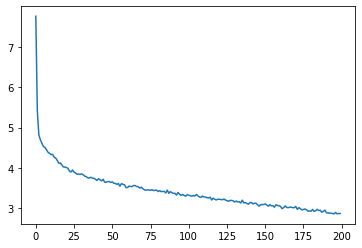

In [44]:
plt.plot(GRU)
plt.show()

## Рассчитаем Bleu score

In [45]:
encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)
gram1_bleu_score = []
gram2_bleu_score = []
for i in range(0,len(testpairs),1):
  
  input_sentence = testpairs[i][0]
  
  reference = testpairs[i][1:]
  templist = []
  for k in range(len(reference)):
    if(reference[k]!=''):
      temp = reference[k].split(' ')
      templist.append(temp)
  
  
  input_sentence = normalizeString(input_sentence)
  output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
  output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
  chencherry = SmoothingFunction()
  score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
  score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
  gram1_bleu_score.append(score1)
  gram2_bleu_score.append(score2)
  if i%1000 == 0:
    print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Общая оценка Bleu Score для 1 грамм тестовых пар: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Общая оценка Bleu Score для 2 грамм тестовых пар: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )  

0 0.14285714285714285 0.048795003647426664
1000 0.14983188364092512 0.06388490997068101
2000 0.14901741338574556 0.06715010967131829
3000 0.14510270911676368 0.06350666355931216
4000 0.14811456374845594 0.06446823916756403
5000 0.14879283896261034 0.06484691237332502
6000 0.14724774320495854 0.06347329342188057
7000 0.1484517378287078 0.06387569049187825
8000 0.14882504662156193 0.06425083017621877
Общая оценка Bleu Score для 1 грамм тестовых пар:  0.14784138843436995
Общая оценка Bleu Score для 2 грамм тестовых пар:  0.06371336407501298


# Чат на GRU

In [ ]:
evaluateInput(encoder, decoder, searcher, voc)

> hi
Black: hi . . . . !
> what are you doing?
Black: i m looking for a phone . . .
> okey
Error: обнаружено неизвестное слово.
> ok
Black: you re not gonna get away with me .
> q


# LSTM

In [46]:
save_dir = os.path.join("/content/drive/My Drive/chatbot/LSTM", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

Начать подготовку данных для обучения ...
Чтение строк...
Прочитано 221282 пар предложений
Сокращено до 64271 пар предложений
Подсчет слов...
Количество слов: 18008


## Собираем Encoder

In [47]:
class EncoderLSTM(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderLSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        
        embedded = self.embedding(input_seq)
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        
        outputs, hidden = self.gru(packed, hidden)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden
    def init_hidden(self):
        
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

## Модуль Decoder

In [48]:
class LuongAttnDecoderLSTM(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderLSTM, self).__init__()

        
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

       
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))#, bidirectional=True)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

# Обучаем модель

### параметры модели

In [56]:
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256

### загрузка контрольной точки

In [57]:
loadFilename = None
checkpoint_iter = 1000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))

### загрузить модель если есть контрольные точки

In [58]:
if loadFilename:
    checkpoint = torch.load(loadFilename)
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

### собираем модель

In [59]:
print('Собираем encoder and decoder ...')

embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

encoder = EncoderLSTM(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderLSTM(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)

encoder = encoder.to(device)
decoder = decoder.to(device)
print('Модель собрана и готова к работе =)!')

Собираем encoder and decoder ...
Модель собрана и готова к работе =)!


### настройки обучения/оптимизации

In [60]:
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 2000
print_every = 10
save_every = 500

In [61]:
encoder.train()
decoder.train()


print('Оптимизатор построен ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)


for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
    

Оптимизатор построен ...


### запуск обучения

In [62]:
print("Начало обучения!")
LSTM = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Начало обучения!
Инициализация ...
Обучение...
Итерация: 10; Процент завершения: 0.5%; Средняя LOSS: 9.0096
Итерация: 20; Процент завершения: 1.0%; Средняя LOSS: 6.2002
Итерация: 30; Процент завершения: 1.5%; Средняя LOSS: 5.3237
Итерация: 40; Процент завершения: 2.0%; Средняя LOSS: 5.2545
Итерация: 50; Процент завершения: 2.5%; Средняя LOSS: 5.1821
Итерация: 60; Процент завершения: 3.0%; Средняя LOSS: 5.1152
Итерация: 70; Процент завершения: 3.5%; Средняя LOSS: 5.0106
Итерация: 80; Процент завершения: 4.0%; Средняя LOSS: 5.0119
Итерация: 90; Процент завершения: 4.5%; Средняя LOSS: 4.9660
Итерация: 100; Процент завершения: 5.0%; Средняя LOSS: 4.9466
Итерация: 110; Процент завершения: 5.5%; Средняя LOSS: 4.9167
Итерация: 120; Процент завершения: 6.0%; Средняя LOSS: 4.9170
Итерация: 130; Процент завершения: 6.5%; Средняя LOSS: 4.8721
Итерация: 140; Процент завершения: 7.0%; Средняя LOSS: 4.9161
Итерация: 150; Процент завершения: 7.5%; Средняя LOSS: 4.8752
Итерация: 160; Процент завершени

# визуализируем результат LSTM

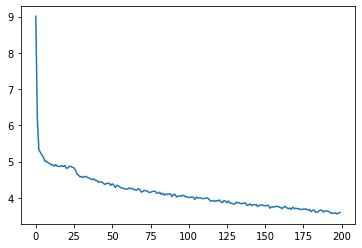

In [63]:
plt.plot(LSTM)
plt.show()

## Рассчитаем Bleu score

In [64]:
encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)
gram1_bleu_score = []
gram2_bleu_score = []
for i in range(0,len(testpairs),1):
  
  input_sentence = testpairs[i][0]
  
  reference = testpairs[i][1:]
  templist = []
  for k in range(len(reference)):
    if(reference[k]!=''):
      temp = reference[k].split(' ')
      templist.append(temp)
  
  
  input_sentence = normalizeString(input_sentence)
  output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
  output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
  chencherry = SmoothingFunction()
  score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
  score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
  gram1_bleu_score.append(score1)
  gram2_bleu_score.append(score2)
  if i%1000 == 0:
    print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Общая оценка Bleu Score для 1 грамм тестовых пар: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Общая оценка Bleu Score для 2 грамм тестовых пар: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )  

0 0.141080287481769 0.04887164517296948
1000 0.16399356405246795 0.07079737591671265
2000 0.16770528621528116 0.07784147174804967
3000 0.16817446027599053 0.07660481448072631
4000 0.17027956131141078 0.07712708061495438
5000 0.1702918312411382 0.07767606266830258
6000 0.16767045999088515 0.07486532998047822
7000 0.1674648001796698 0.07468837960974696
8000 0.16783366586567208 0.07552432411860321
Общая оценка Bleu Score для 1 грамм тестовых пар:  0.1670786261643222
Общая оценка Bleu Score для 2 грамм тестовых пар:  0.07497288187361803


# Чат на LSTM

In [ ]:
evaluateInput(encoder, decoder, searcher, voc)

> hi
Black: hi . . . . !
> what are you doing?
Black: i m looking for a phone . . .
> okey
Error: обнаружено неизвестное слово.
> ok
Black: you re not gonna get away with me .
> q
